# link of the dataset
https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Path of Data

In [2]:
train_path = r'C:\Users\Mohamed Hamde\Data Science\Projects Deep Learning/SatelliteImageSplit\train'
val_path = r'C:\Users\Mohamed Hamde\Data Science\Projects Deep Learning/SatelliteImageSplit\val'
test_path = r'C:\Users\Mohamed Hamde\Data Science\Projects Deep Learning/SatelliteImageSplit\test'

# Get the Data and Resize it 

In [71]:
train_batches = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, target_size=(224, 224), batch_size=3941)

val_batches = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    val_path, target_size=(224, 224), batch_size=1126)

test_batches = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path, target_size=(224, 224), batch_size=564)

Found 3941 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.
Found 564 images belonging to 4 classes.


# Classes of Data

In [5]:
classes = train_batches.class_indices
classes

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}

In [6]:
labels = []
for key, value in classes.items():
    labels.append(key)

# Split the Data for images and labels

In [7]:
X_train, y_train = next(train_batches)
X_val, y_val = next(val_batches)
X_test, y_test = next(test_batches)

# Show some of images

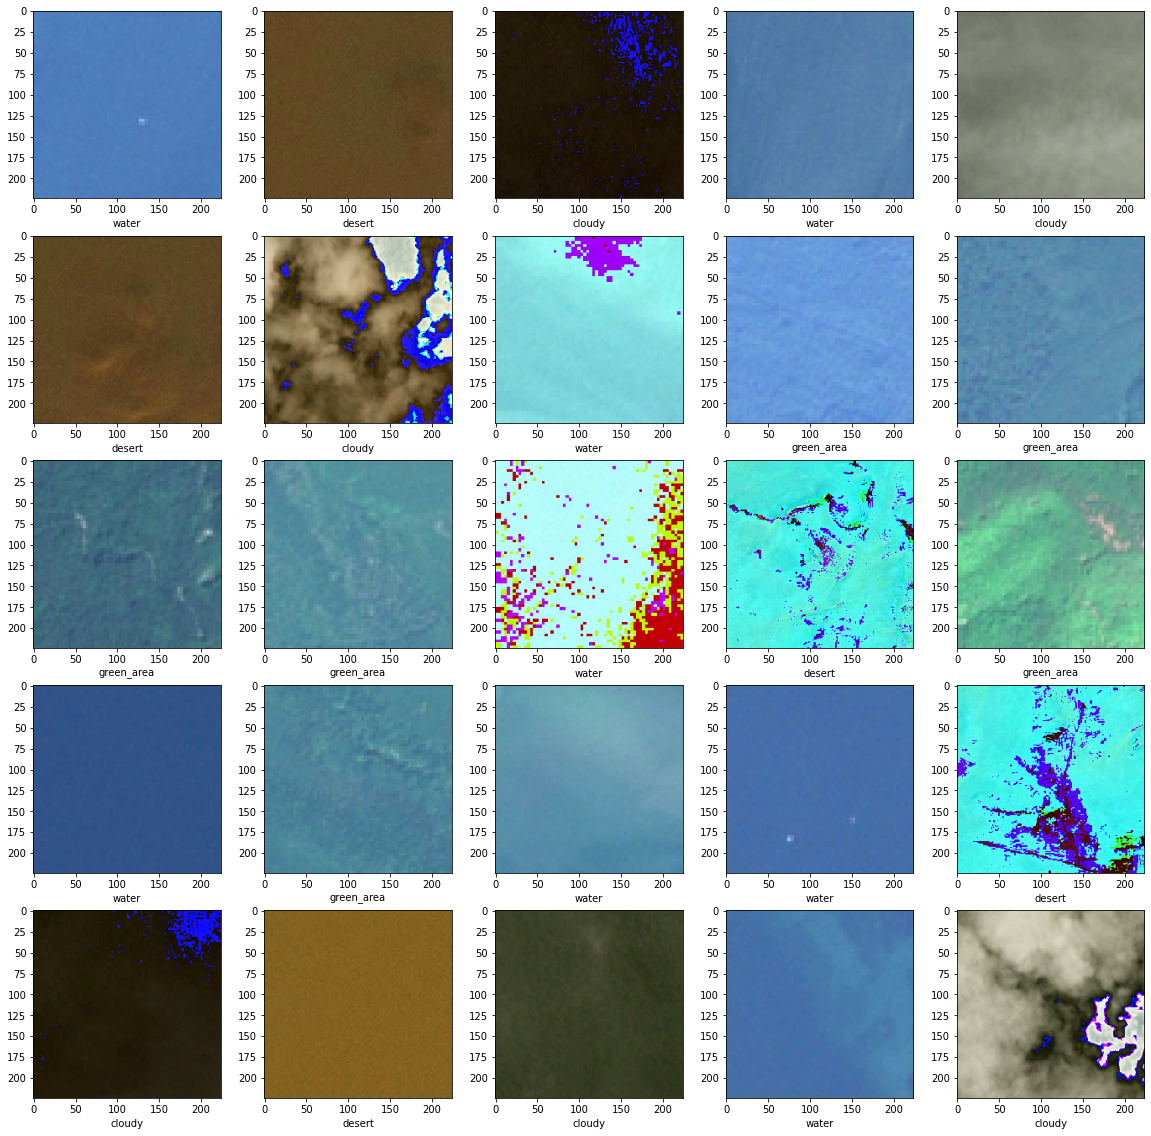

In [15]:
plt.figure(figsize=(20,20))
for n, i in enumerate(np.random.randint(0, len(X_train), 25)):
    plt.subplot(5, 5, n+1)
    plt.imshow((X_train[i]*255).astype(np.uint8))
    plt.xlabel(labels[np.argmax(y_train[i])])

# Using ImageDataGenerator

In [16]:
img_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = img_train_datagen.flow(X_train, y_train, batch_size=30)
valid_generator = img_train_datagen.flow(X_val, y_val)

# Calling the Model (Mobile Net)

In [17]:
mobilnet = tf.keras.applications.mobilenet.MobileNet(dropout=0.4)

# Freezing the Layers except the output

In [18]:
model_mobilenet = tf.keras.models.Sequential()
for layer in mobilnet.layers[:-1]:
    model_mobilenet.add(layer)

In [19]:
for layer in model_mobilenet.layers:
    layer.trainable = False

# Create the output layer

In [20]:
model_mobilenet.add(tf.keras.layers.Dense(4, activation='softmax'))

# Summary of Model

In [21]:
model_mobilenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pw_1 (Conv2D)           (None, 112, 112, 64)      2

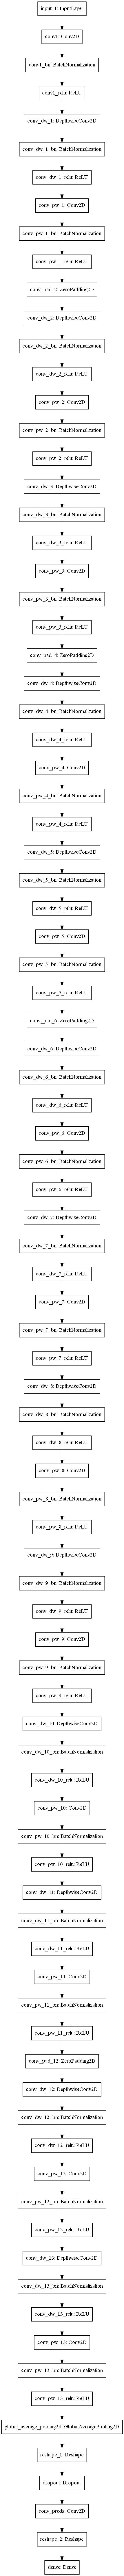

In [22]:
tf.keras.utils.plot_model(model_mobilenet, to_file='model.jpg')

# Optimization the Model

In [23]:
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Using the Callbacks

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Fitting the Model

In [58]:
history = model_mobilenet.fit(train_generator,  batch_size=64, epochs=4, validation_data=valid_generator ,verbose=1, callbacks=[reduce_lr, early_stopping])

Epoch 1/4
132/132 [==============================] - 126s 950ms/step - loss: 0.1291 - accuracy: 0.9574 - val_loss: 0.0573 - val_accuracy: 0.9796
Epoch 2/4
132/132 [==============================] - 121s 920ms/step - loss: 0.0942 - accuracy: 0.9683 - val_loss: 0.0446 - val_accuracy: 0.9796
Epoch 3/4
132/132 [==============================] - 126s 953ms/step - loss: 0.1102 - accuracy: 0.9650 - val_loss: 0.0414 - val_accuracy: 0.9867
Epoch 4/4
132/132 [==============================] - 125s 948ms/step - loss: 0.0900 - accuracy: 0.9690 - val_loss: 0.0269 - val_accuracy: 0.9920


# Prediction and Evaluate the Model

In [59]:
predictions = model_mobilenet.predict(X_test, verbose=0)

In [60]:
acc = model_mobilenet.evaluate(X_test, y_test)
print(acc)

18/18 [==============================] - 9s 510ms/step - loss: 0.0362 - accuracy: 0.9894
[0.036195576190948486, 0.9893617033958435]


# Plotting the Results to know if there is Overfitting or no!

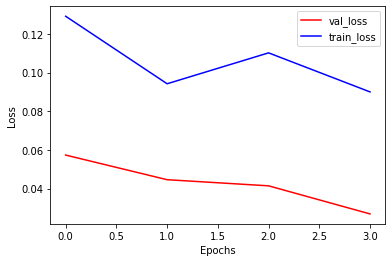

In [61]:
plt.plot(history.history['val_loss'], color='red', label='val_loss')
plt.plot(history.history['loss'], color='blue', label='train_loss')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

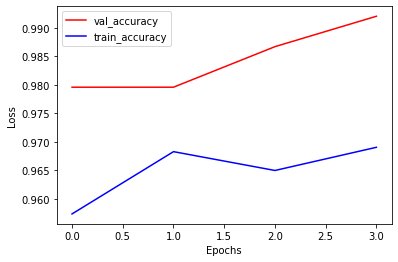

In [62]:
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train_accuracy')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

# Show the Predictions

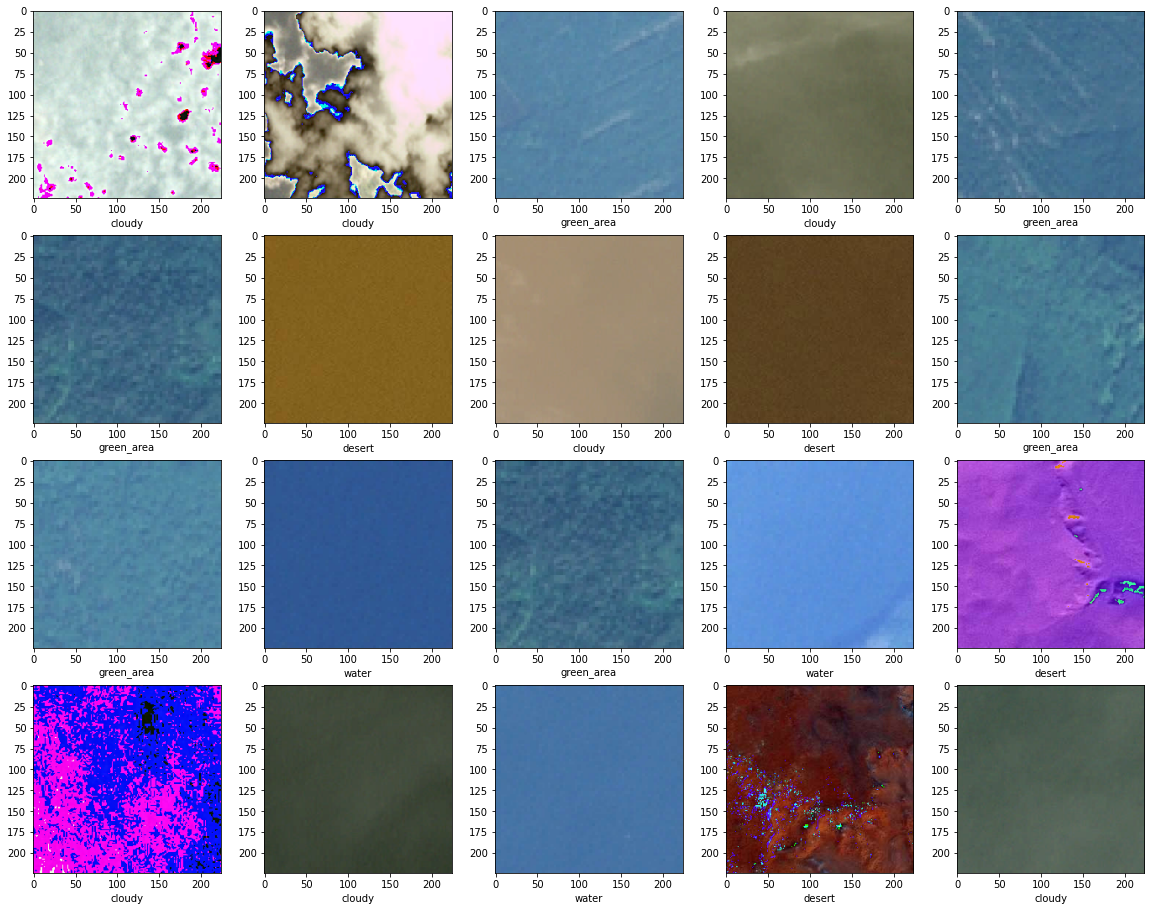

In [63]:
plt.figure(figsize=(20, 20))
for n, i in enumerate(np.random.randint(0, len(predictions), 20)):
    plt.subplot(5, 5, n+1)
    plt.imshow((X_test[i]*255).astype(np.uint8))
    plt.xlabel(labels[np.argmax(predictions[i])])

# Confusion Matrix

In [66]:
conf = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

<AxesSubplot:>

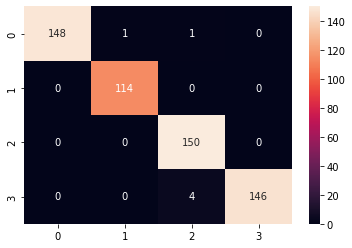

In [67]:
sns.heatmap(conf, annot= True, fmt='d')

# Classification Report

In [70]:
clas = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(clas)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       150
           1       0.99      1.00      1.00       114
           2       0.97      1.00      0.98       150
           3       1.00      0.97      0.99       150

    accuracy                           0.99       564
   macro avg       0.99      0.99      0.99       564
weighted avg       0.99      0.99      0.99       564

